In [50]:
import pandas as pd
import numpy as np
import re
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

from sklearn.metrics import f1_score

In [51]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

In [52]:
# Normal dataset
#df = pd.read_csv("domain_data_with_identities.csv")

# Epsilon 0,1 fair dataset
df = pd.read_csv("domain_data_with_identities_private_xtrain0,1.csv")

# Epsilon 0,01 fair dataset
#df = pd.read_csv("domain_data_with_identities_private_xtrain0,1.csv")

df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))


In [103]:
# Updating values for training_data
training_data = df[df['split'] == 'train']
#training_data = training_data.drop(training_data.query('toxicity==0').sample(frac=.85).index)

# Getting test_data
test_data = df[df['split'] == 'test']

# Getting validation_data
validation_data = df[df['split'] == 'val']
#validation_data = validation_data.drop(validation_data.query('toxicity==0').sample(frac=.85).index)

In [112]:
print('Toxic samples training data: ', sum(training_data['toxicity']))
print('None-toxic samples training data: ', len(training_data['toxicity'])-sum(training_data['toxicity']))

print("\n")
print('Toxic samples validation data: ', sum(validation_data['toxicity']))
print('None-toxic samples validation data: ', len(validation_data['toxicity'])-sum(validation_data['toxicity']))

print("\n")
print('Toxic samples test data: ', sum(test_data['toxicity']))
print('None-toxic samples test data: ', len(test_data['toxicity'])-sum(test_data['toxicity']))

print("\n")

for col in training_data.columns[3:]:
    print(col + ": " + str(np.sum(training_data[col])))

Toxic samples training data:  11358.0
None-toxic samples training data:  87747.0


Toxic samples validation data:  1878.0
None-toxic samples validation data:  14552.0


Toxic samples test data:  5640.0
None-toxic samples test data:  42235.0


male: 26894.0
female: 34305.0
LGBTQ: 8420
christian: 23475.0
muslim: 13080.0
other_religion: 49.0
black: 9207.0
white: 15855.0


In [55]:
### Set parameters for the model
#torch.manual_seed(42) # set fixed random seed for reproducibility
batch_size = 128
epochs = 1000
lr = 0.0001

cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

Using device(type='cuda')


In [113]:
transform = transforms.Compose([transforms.ToTensor()])

# Creating data loaders
X_train = np.array(training_data['comment_text'].values.tolist())
Y_train = np.array(training_data['toxicity'].values.tolist())

X_test = np.array(test_data['comment_text'].values.tolist())
Y_test = np.array(test_data['toxicity'].values.tolist())

X_val = np.array(validation_data['comment_text'].values.tolist())
Y_val = np.array(validation_data['toxicity'].values.tolist())

                    
prepare_trainloader = []
for i in range(len(X_train)):
    prepare_trainloader.append([X_train[i], Y_train[i]])
    
prepare_testloader = []
for i in range(len(X_test)):
    prepare_testloader.append([X_test[i], Y_test[i]])
    
prepare_validloader = []
for i in range(len(X_val)):
    prepare_validloader.append([X_val[i], Y_val[i]])

train_loader = torch.utils.data.DataLoader(prepare_trainloader, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(prepare_validloader, batch_size=len(prepare_validloader), shuffle=False)
test_loader = torch.utils.data.DataLoader(prepare_testloader, batch_size=batch_size, shuffle=False)

In [118]:
for batch_idx, data in enumerate(valid_loader):
    print(batch_idx, data[0].shape)

0 torch.Size([16430, 768])


In [69]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)

In [70]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(768, 64), nn.ReLU(), nn.Dropout(p=0.2))
        self.fc2 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        #self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [77]:
# Setting up model parameters
model = Net().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_function = nn.BCELoss()
#loss_function = nn.MSELoss()
#loss_function = nn.NLLLoss()

# Initialising early stopping criterias
early_stopping = 30
notImproved = 0
bestLoss = None
bestModel = None

trainArr = []
valArr = []

bestf1 = 0

for epoch in range(1, epochs + 1):
    
    train_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        
        # get the input
        inputs, labels = data
        
        inputs = inputs.unsqueeze(1)
        
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize            
        outputs = model(inputs).squeeze()
        
        
        loss = loss_function(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader.dataset)
    
    print('====> Epoch: {} Average training loss: {:.6f}'.format(epoch, train_loss))
    
    trainArr.append(train_loss)
    
    valid_loss = 0
    labs = []
    preds = []
    
    model.eval()
    with torch.no_grad():        
        for batch_idx, data in enumerate(valid_loader):
            # get the input
            inputs, labels = data
            inputs = inputs.unsqueeze(1)
            inputs = inputs.to(device).float()
            #labels = labels.to(device).long()
            labels = labels.to(device).float()
            
            outputs = model(inputs).squeeze()
            
            labs.extend(labels)
            preds.extend(torch.round(outputs))
            #preds.extend(outputs.argmax(axis=1))
            
            valid_loss += loss_function(outputs, labels).item()
    
    valid_loss /= len(valid_loader.dataset)
    
    valArr.append(valid_loss)
    
    print('====> Validation set loss: {:.6f}'.format(valid_loss))
    
    print("Accuracy on Validation set: ", CheckAccuracy(labs, preds))
    
    f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
    
    print("F1_score: ", f1)
    if f1 > bestf1:
        bestModel = model
    
    print("\n")
    
    # Initialising params for early stopping
    if bestLoss == None:
        bestLoss = valid_loss
        
    # Checks for early stopping
    if valid_loss <= bestLoss:
        notImproved = 0
        bestLoss = valid_loss
        #bestModel = model
    else:
        notImproved +=1
        
    # Converges if the training has not improved for a certain amount of iterations
    if notImproved >= early_stopping:
        break

#if bestModel != None:
model = bestModel
    

#torch.save(model, 'bestModelFullyConnectedNetwork0,1Fair.pth')

====> Epoch: 1 Average training loss: 0.005125
====> Validation set loss: 0.005487
Accuracy on Validation set:  0.4782073380940655
F1_score:  0.6228866346324968


====> Epoch: 2 Average training loss: 0.004589
====> Validation set loss: 0.005463
Accuracy on Validation set:  0.5215464171386358
F1_score:  0.5513738166705149


====> Epoch: 3 Average training loss: 0.004482
====> Validation set loss: 0.005443
Accuracy on Validation set:  0.5180989903964541
F1_score:  0.3327650869416979


====> Epoch: 4 Average training loss: 0.004441
====> Validation set loss: 0.005446
Accuracy on Validation set:  0.5213001723713371
F1_score:  0.10083256244218317


====> Epoch: 5 Average training loss: 0.004414
====> Validation set loss: 0.005466
Accuracy on Validation set:  0.5328736764343758
F1_score:  0.03263640999490056


====> Epoch: 6 Average training loss: 0.004390
====> Validation set loss: 0.005495
Accuracy on Validation set:  0.5368135927111549
F1_score:  0.00947867298578199


====> Epoch: 7 Aver

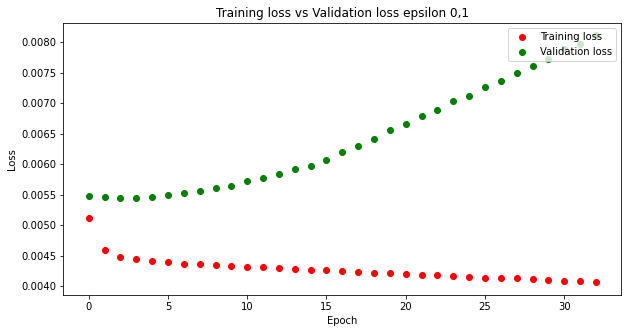

In [78]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(0,len(trainArr)), trainArr, color='r', label='Training loss')
plt.scatter(np.arange(0,len(valArr)), valArr, color='g', label='Validation loss')
plt.title("Training loss vs Validation loss epsilon 0,1")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [79]:
def F1_Scores(preds, labels):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i in range(len(labs)):
        if labels[i]==1 and preds[i]==1:
            true_positives += 1
        if labels[i]==0 and preds[i]==0:
            true_negatives += 1
        if labels[i]==0 and preds[i]==1:
            false_positives += 1
        if labels[i]==1 and preds[i]==0:
            false_negatives += 1
    print("true_positives", true_positives)
    print("true_negatives", true_negatives)
    print("false_positives", false_positives)
    print("false_negatives", false_negatives)
    
    return true_positives, true_negatives, false_positives, false_negatives

In [80]:
labs = []
preds = []

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(test_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on test set: ", CheckAccuracy(labs, preds))

f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
print("F1_score: ", f1)

true_positives, true_negatives, false_positives, false_negatives = F1_Scores(preds, labs)

print("Toxic accuracy: ", true_positives/5640)
print("Non-toxic accuracy: ", true_negatives/42235)

Accuracy on test set:  0.8821723237597912
F1_score:  0.0
true_positives 0
true_negatives 42234
false_positives 1
false_negatives 5640
Toxic accuracy:  0.0
Non-toxic accuracy:  0.9999763229548952


In [122]:
from diffprivlib.models import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

epsilons = [0.0001, 0.001, 0.01, 0.1, 1, 10]



for eps in epsilons:
    print(eps)
    clf = LogisticRegression(epsilon=eps)
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_test)
    f1 = f1_score(predictions, Y_test, zero_division=1)
    
    print("F1_score: ", f1)
    
    print(clf.score(X_test, Y_test))
    
    F1_Scores(predictions, Y_test)

#predictions = np.array(predictions).reshape(len(predictions), 1)
#Y_test = np.array(Y_test).reshape(len(Y_test), 1)

    

0.0001


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


F1_score:  0.16722284019280684
0.6246892950391645
true_positives 1804
true_negatives 28103
false_positives 14132
false_negatives 3836
0.001


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


F1_score:  0.18976664981507596
0.3639477806788512
true_positives 3566
true_negatives 13858
false_positives 28377
false_negatives 2074
0.01


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


F1_score:  0.13047295072972676
0.6689712793733682
true_positives 1189
true_negatives 30838
false_positives 11397
false_negatives 4451
0.1


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


F1_score:  0.19447133483919543
0.5307154046997389
true_positives 2712
true_negatives 22696
false_positives 19539
false_negatives 2928
1


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


F1_score:  0.24124605678233438
0.5980783289817232
true_positives 3059
true_negatives 25574
false_positives 16661
false_negatives 2581
10


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


F1_score:  0.2696797241723092
0.6327728459530026
true_positives 3246
true_negatives 27048
false_positives 15187
false_negatives 2394


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
